In [ ]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchdiffeq import odeint

def seq_mlp(init, mlp, fin, act):
    modules = [nn.Linear(init, mlp[0]), act]
    for i in range(len(mlp) - 1):
        modules.append(nn.Linear(mlp[i], mlp[i+1]))
        modules.append(act)

    modules.append(nn.Linear(mlp[-1], fin)) #self.spl for spline

    return modules

In [ ]:
class EvalEig(nn.Module):
    def __init__(self, para, evl):
        super().__init__()
        self.rn = para['rn']
        self.rm = para['rm']
        self.r_dsc = torch.linspace(self.rm/self.rn, self.rm, self.rn)
        
        self.evl = evl
        
        ptl_modules = seq_mlp(init = 1, mlp = para['mlp'], fin = 1, act = nn.ReLU())
        self.ptl_mlp = nn.Sequential(*ptl_modules)
    
    def ode_func(self, r_dsc, init_rad):
        rad = init_rad[:,0]
        rad_d = init_rad[:,1]
        
        #ptl_rs = self.ptl_mlp(r_dsc.view(-1)).expand(self.evl.shape[0])
        ptl_rs = -2/r_dsc.view(-1).expand(self.evl.shape[0])
        evl_rs = self.evl # shape B x 1 x 1

        rad_dd = (ptl_rs - evl_rs) * rad

        derivs = torch.stack([rad_d, rad_dd.squeeze(-1)],dim=-1)
        return derivs

    def forward(self):
        init_rad_rs = torch.stack([torch.zeros(self.evl.shape[0]),
                                   torch.ones(self.evl.shape[0])],dim=-1)
        rad_md = odeint(self.ode_func, init_rad_rs, self.r_dsc,
                        rtol = 1e-6, atol = 1e-9, method='dopri5')

        return rad_md

In [ ]:
para = {
        'rm' : 200,
        'rn' : 10000,

        # model
        'mlp' : [10,10,10],

        # training
        'epoch' : 1000,
        'lr' : 1e-2,

        # loss regularisation
        'reg0' : 1,
        'reg1' : 0,
        'reg2' : 1e4,
}


#evl_tr = -torch.arange(1,100).to(torch.float32)**(-2)/1000
evl_tr = torch.linspace(-0.05,0.1,1000)

model = EvalEig(para, evl_tr)

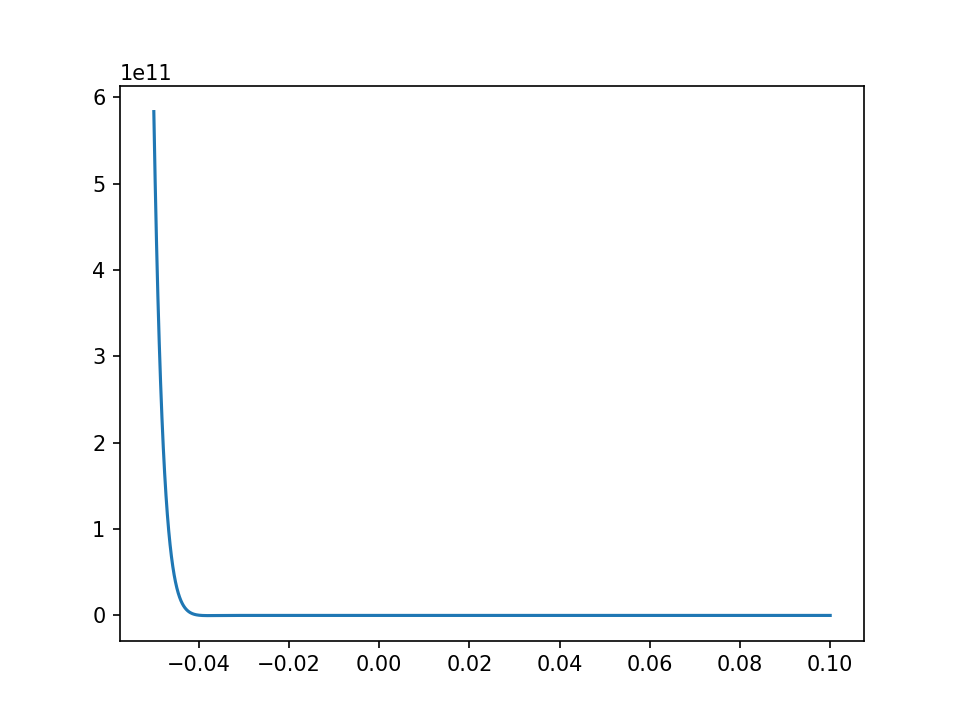

In [1]:
optimiser = torch.optim.Adam(model.parameters(), lr = para['lr'])
epochs = para['epoch']
pbar = tqdm(range(epochs), desc='Progress', total=epochs, leave = True, position=0, colour='blue')
loss_list = [[],[],[]]

rad_md = model()
plt.figure()
plt.plot(evl_tr,rad_md[-1,:,0])

In [ ]:
for e in range(epochs):
    #with torch.autograd.detect_anomaly():
    ptl_md, rad_md, loss0 = model()
    
    loss1 = torch.abs(ptl_md[-1])
    loss2 = torch.sqrt(torch.sum(rad_md[:,0]**2 + rad_md[:,-1]**2))
    loss = para['reg0']*loss0 + para['reg1']*loss1 + para['reg2']*loss2

    loss_list[0].append(loss0.item())
    loss_list[1].append(loss1.item())
    loss_list[2].append(loss2.item())

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    pbar.update()
    #print(loss.item())

In [ ]:
plt.figure()
plt.plot(model.r_dsc.detach(), ptl_md.detach())
plt.show()

In [ ]:
plt.figure()
plt.plot(model.r_dsc.detach(), rad_md[0].detach())
plt.plot(model.r_dsc.detach(), rad_md[1].detach())
plt.plot(model.r_dsc.detach(), rad_md[2].detach())
plt.show()

In [ ]:
plt.figure()
j = 0
print(loss0.item(),loss1.item(),loss2.item())
plt.plot(np.arange(j,epochs), loss_list[0][j:])
#plt.plot(np.arange(j,epochs), loss_list[1][j:])
plt.plot(np.arange(j,epochs), loss_list[2][j:])